<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Network-Analytics:-Centrality" data-toc-modified-id="Network-Analytics:-Centrality-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Network Analytics: Centrality</a></span><ul class="toc-item"><li><span><a href="#Degree-Centrality" data-toc-modified-id="Degree-Centrality-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Degree Centrality</a></span></li><li><span><a href="#Eigenvector-centrality" data-toc-modified-id="Eigenvector-centrality-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Eigenvector centrality</a></span></li></ul></li></ul></div>

In [4]:
import matplotlib.pyplot as plt
import itertools
import networkx as nx 
import numpy as np

# Network Analytics: Centrality

In network analysis we often seek to distill the large network into a few attributes so that we can better understand its structure. A good place to start is finding which subgraphs of the network contain the most information. Thinking of nodes as the most elementary subgraph we arrive at our first step in understanding our network: *Which nodes are most important?*

This is what data scientists refer to as **Node Centrality** and is a Local-Scale Feature.

## Degree Centrality
What if we simply measured a node's important by how many nodes it is connected to? Also known as Degree Centrality, it takes a myopic approach to a node's importance. Let's say that you are friends with 40 people, but your friend Jake is only friends with 10. Degree centrality would say that you are more important in the social network than Jake, but what it failed to account for is that one of Jake's 10 friends was the President of the United States!

Now, let's setup this proposed social network and see how degree centrality performs.

In [5]:
A = np.zeros((150,150))
A[0,:101] = 1 # POTUS is friends with 100 people and jake
A[1,101:110] = 1 # Jake has 10 friends including the prdesident
A[2, 110:] = 1 # youre friends with 39 people
A[2, 1] = 1 # youre friends with Jake
A[0, 2] = 0 # youre not friends with the president
net = nx.from_numpy_matrix(A) # Create the networkx object
nx.relabel_nodes(net, {0: 'President', 1: 'Jake', 2:'You'}, copy=False) # Name the important nodes

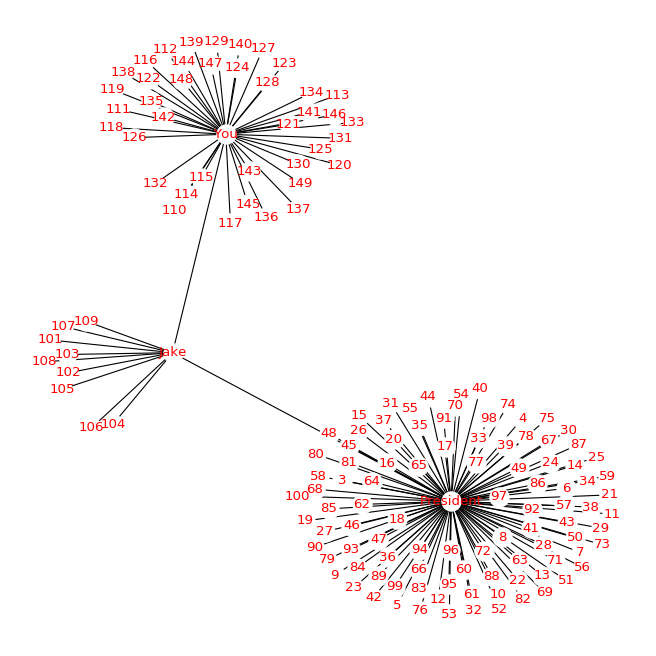

In [6]:
# Visualize the network
plt.figure(num=None, figsize=(8, 8), dpi=80)
layout = nx.spring_layout(net,k=0.2)
nx.draw(net, pos=layout, node_color='white')
labels = nx.draw_networkx_labels(net, pos=layout, font_color='red')

In [7]:
# Now let's test Degree Centrality!
d = nx.degree_centrality(net)
d = {k: v for k, v in sorted(d.items(), key=lambda item: item[1], reverse=True)} # Sort by centrality score
dict(itertools.islice(d.items(), 4)) # Show me the top 4

{'President': 0.6778523489932886,
 'You': 0.2751677852348993,
 'Jake': 0.0738255033557047,
 3: 0.006711409395973154}

Are you really more important in the social network than Jake given that he knows the President of the United States? We need a measure that accounts for the importance of its neighboring nodes (i.e. the importance of your friends).

## Eigenvector centrality
If you have a computer science background you can probably sense recursion is near, but don't worry, eigenvectors will save the day!

We define the importance of node i as $$\phi(i)=k\sum_{j=1}^{n}A(i,j)\phi(j)$$ where A is the adjacency matrix.

All this means is that the importance of node i is the sum of the importance of its neighboring nodes. In the social network example, your importance is the sum of the importance of your friends. This recursive approach does not seem very attractive, but if we rearrange things an important pattern emerges:

First, notice that $\sum_{j=1}^{n}A(i,j)\phi(j)$ is the element-wise view of matrix-vector multiplication: $\sum_{j=1}^{n}A_{i,j}x_j=Ax$
$$\phi(i)=k\sum_{j=1}^{n}A(i,j)\phi(j)$$
$$\phi=k(A\phi)$$
$$A\phi = \frac{1}{k}\phi$$

This last expression is simply an eigenvector problem\* with eigenpair: $(\lambda=\frac{1}{k}, v=\phi)$.

\*Recall canonical form $Av=\lambda v$

Therefore, although the recursive definition is easier to understand, we can solve for each node's centrality score  by simply solving the eigenvector problem (i.e. find $\phi$) once.

Another important property to note is that since the adjacency matrix for an undirected graph will be real and symmetric, we can apply the Perron-Frobenius Theorem: ***Finding the eigenvector of A corresponding to its largest eigenvalue yields real and positive centrality scores for each node. These are relative scores and we can scale these values to be [0,1].***

In [8]:
# Let's check that the norm is 1
np.linalg.norm([x for x in d.values()])

0.7397787813774699

In [9]:
d = nx.eigenvector_centrality(net)
d = {k: v for k, v in sorted(d.items(), key=lambda item: item[1], reverse=True)} # Sort by centrality score
dict(itertools.islice(d.items(), 4)) # Show me the top 4

{'President': 0.7241835755587369,
 'Jake': 0.07657101083301115,
 3: 0.06918123709391014,
 4: 0.06918123709391014}

This is a more believable result, with Jake and the President ranking much higher than you. Where are you ranked?

In [10]:
print('You ranked', list(d.keys()).index('You'), 'out of', len(d))

You ranked 100 out of 150


This result makes sense because you are 2 degrees of separation from the president: You-Jake-President. And your friends are 3 degrees of separation from the president: Friend-You-Jake-President. Therefore it makes sense that the centrality scores should be structured to reflect these degrees of separation.